# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

## Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [165]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import numpy as np

import catboost as ctb
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import KFold, RandomizedSearchCV

import scikitplot as skplt

import scipy.stats as sps

from tqdm import trange, tqdm

from IPython.display import clear_output

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [5]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [6]:
pca = PCA(0.99)

In [7]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [8]:
X_train_pca.shape

(7352, 179)

In [9]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

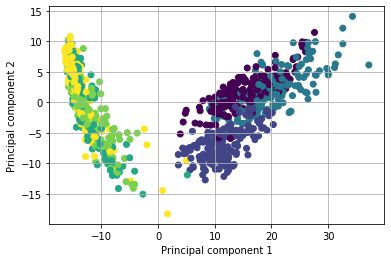

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

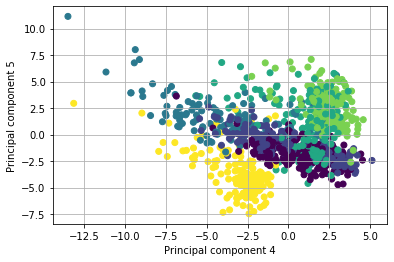

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

### Выясним на каком типе данных лучше обучаться

In [12]:
model = ctb.CatBoostClassifier()

* Чистый train/test

In [13]:
model.fit(X_train, y_train)

Learning rate set to 0.087601
0:	learn: 1.4924924	total: 501ms	remaining: 8m 20s
1:	learn: 1.3053988	total: 722ms	remaining: 6m
2:	learn: 1.1501569	total: 974ms	remaining: 5m 23s
3:	learn: 1.0279013	total: 1.27s	remaining: 5m 15s
4:	learn: 0.9299029	total: 1.65s	remaining: 5m 27s
5:	learn: 0.8505377	total: 1.86s	remaining: 5m 7s
6:	learn: 0.7815606	total: 2.1s	remaining: 4m 58s
7:	learn: 0.7184832	total: 2.32s	remaining: 4m 47s
8:	learn: 0.6682108	total: 2.78s	remaining: 5m 6s
9:	learn: 0.6244669	total: 3.08s	remaining: 5m 4s
10:	learn: 0.5829198	total: 3.32s	remaining: 4m 58s
11:	learn: 0.5455638	total: 3.65s	remaining: 5m
12:	learn: 0.5137422	total: 3.91s	remaining: 4m 56s
13:	learn: 0.4841563	total: 4.12s	remaining: 4m 50s
14:	learn: 0.4577188	total: 4.39s	remaining: 4m 48s
15:	learn: 0.4346884	total: 4.61s	remaining: 4m 43s
16:	learn: 0.4118455	total: 4.87s	remaining: 4m 41s
17:	learn: 0.3899194	total: 5.09s	remaining: 4m 37s
18:	learn: 0.3710220	total: 5.33s	remaining: 4m 35s
19:	

158:	learn: 0.0523908	total: 40.4s	remaining: 3m 33s
159:	learn: 0.0520891	total: 40.7s	remaining: 3m 33s
160:	learn: 0.0518504	total: 40.9s	remaining: 3m 33s
161:	learn: 0.0512893	total: 41.2s	remaining: 3m 32s
162:	learn: 0.0510291	total: 41.5s	remaining: 3m 32s
163:	learn: 0.0509699	total: 41.7s	remaining: 3m 32s
164:	learn: 0.0505653	total: 42s	remaining: 3m 32s
165:	learn: 0.0503712	total: 42.3s	remaining: 3m 32s
166:	learn: 0.0502016	total: 42.5s	remaining: 3m 32s
167:	learn: 0.0499887	total: 42.8s	remaining: 3m 31s
168:	learn: 0.0496708	total: 43s	remaining: 3m 31s
169:	learn: 0.0495203	total: 43.3s	remaining: 3m 31s
170:	learn: 0.0492067	total: 43.5s	remaining: 3m 30s
171:	learn: 0.0490410	total: 43.8s	remaining: 3m 30s
172:	learn: 0.0488990	total: 44s	remaining: 3m 30s
173:	learn: 0.0485110	total: 44.2s	remaining: 3m 29s
174:	learn: 0.0483366	total: 44.5s	remaining: 3m 29s
175:	learn: 0.0481415	total: 44.7s	remaining: 3m 29s
176:	learn: 0.0478463	total: 44.9s	remaining: 3m 28s

314:	learn: 0.0259376	total: 1m 19s	remaining: 2m 52s
315:	learn: 0.0258722	total: 1m 19s	remaining: 2m 51s
316:	learn: 0.0257501	total: 1m 19s	remaining: 2m 51s
317:	learn: 0.0256022	total: 1m 19s	remaining: 2m 51s
318:	learn: 0.0254397	total: 1m 20s	remaining: 2m 51s
319:	learn: 0.0252599	total: 1m 20s	remaining: 2m 50s
320:	learn: 0.0252112	total: 1m 20s	remaining: 2m 50s
321:	learn: 0.0250914	total: 1m 20s	remaining: 2m 50s
322:	learn: 0.0250096	total: 1m 21s	remaining: 2m 50s
323:	learn: 0.0249262	total: 1m 21s	remaining: 2m 49s
324:	learn: 0.0248900	total: 1m 21s	remaining: 2m 49s
325:	learn: 0.0247625	total: 1m 21s	remaining: 2m 49s
326:	learn: 0.0246557	total: 1m 22s	remaining: 2m 49s
327:	learn: 0.0245724	total: 1m 22s	remaining: 2m 48s
328:	learn: 0.0244707	total: 1m 22s	remaining: 2m 48s
329:	learn: 0.0244073	total: 1m 22s	remaining: 2m 48s
330:	learn: 0.0243427	total: 1m 23s	remaining: 2m 48s
331:	learn: 0.0242656	total: 1m 23s	remaining: 2m 47s
332:	learn: 0.0242020	total:

466:	learn: 0.0166531	total: 1m 56s	remaining: 2m 12s
467:	learn: 0.0165892	total: 1m 56s	remaining: 2m 12s
468:	learn: 0.0165685	total: 1m 56s	remaining: 2m 12s
469:	learn: 0.0165372	total: 1m 57s	remaining: 2m 12s
470:	learn: 0.0164860	total: 1m 57s	remaining: 2m 11s
471:	learn: 0.0164171	total: 1m 57s	remaining: 2m 11s
472:	learn: 0.0163423	total: 1m 57s	remaining: 2m 11s
473:	learn: 0.0163046	total: 1m 58s	remaining: 2m 10s
474:	learn: 0.0162772	total: 1m 58s	remaining: 2m 10s
475:	learn: 0.0162522	total: 1m 58s	remaining: 2m 10s
476:	learn: 0.0162372	total: 1m 58s	remaining: 2m 10s
477:	learn: 0.0162068	total: 1m 59s	remaining: 2m 9s
478:	learn: 0.0161839	total: 1m 59s	remaining: 2m 9s
479:	learn: 0.0161118	total: 1m 59s	remaining: 2m 9s
480:	learn: 0.0160481	total: 1m 59s	remaining: 2m 9s
481:	learn: 0.0160229	total: 1m 59s	remaining: 2m 8s
482:	learn: 0.0159444	total: 2m	remaining: 2m 8s
483:	learn: 0.0159212	total: 2m	remaining: 2m 8s
484:	learn: 0.0158553	total: 2m	remaining: 

620:	learn: 0.0114824	total: 2m 31s	remaining: 1m 32s
621:	learn: 0.0114285	total: 2m 31s	remaining: 1m 32s
622:	learn: 0.0114073	total: 2m 31s	remaining: 1m 31s
623:	learn: 0.0113897	total: 2m 32s	remaining: 1m 31s
624:	learn: 0.0113517	total: 2m 32s	remaining: 1m 31s
625:	learn: 0.0113115	total: 2m 32s	remaining: 1m 31s
626:	learn: 0.0112849	total: 2m 32s	remaining: 1m 31s
627:	learn: 0.0112633	total: 2m 33s	remaining: 1m 30s
628:	learn: 0.0112234	total: 2m 33s	remaining: 1m 30s
629:	learn: 0.0112046	total: 2m 33s	remaining: 1m 30s
630:	learn: 0.0111955	total: 2m 33s	remaining: 1m 30s
631:	learn: 0.0111816	total: 2m 34s	remaining: 1m 29s
632:	learn: 0.0111597	total: 2m 34s	remaining: 1m 29s
633:	learn: 0.0111323	total: 2m 34s	remaining: 1m 29s
634:	learn: 0.0111044	total: 2m 34s	remaining: 1m 28s
635:	learn: 0.0110712	total: 2m 35s	remaining: 1m 28s
636:	learn: 0.0110369	total: 2m 35s	remaining: 1m 28s
637:	learn: 0.0110279	total: 2m 35s	remaining: 1m 28s
638:	learn: 0.0110215	total:

774:	learn: 0.0084159	total: 3m 11s	remaining: 55.6s
775:	learn: 0.0083901	total: 3m 12s	remaining: 55.5s
776:	learn: 0.0083801	total: 3m 12s	remaining: 55.3s
777:	learn: 0.0083566	total: 3m 13s	remaining: 55.1s
778:	learn: 0.0083442	total: 3m 13s	remaining: 54.9s
779:	learn: 0.0083289	total: 3m 13s	remaining: 54.7s
780:	learn: 0.0083082	total: 3m 14s	remaining: 54.4s
781:	learn: 0.0083052	total: 3m 14s	remaining: 54.1s
782:	learn: 0.0082855	total: 3m 14s	remaining: 53.9s
783:	learn: 0.0082701	total: 3m 14s	remaining: 53.6s
784:	learn: 0.0082625	total: 3m 14s	remaining: 53.4s
785:	learn: 0.0082579	total: 3m 15s	remaining: 53.1s
786:	learn: 0.0082362	total: 3m 15s	remaining: 52.9s
787:	learn: 0.0082205	total: 3m 15s	remaining: 52.6s
788:	learn: 0.0081956	total: 3m 15s	remaining: 52.4s
789:	learn: 0.0081812	total: 3m 16s	remaining: 52.1s
790:	learn: 0.0081699	total: 3m 16s	remaining: 51.9s
791:	learn: 0.0081597	total: 3m 16s	remaining: 51.6s
792:	learn: 0.0081437	total: 3m 16s	remaining:

929:	learn: 0.0064739	total: 3m 50s	remaining: 17.4s
930:	learn: 0.0064665	total: 3m 51s	remaining: 17.1s
931:	learn: 0.0064559	total: 3m 51s	remaining: 16.9s
932:	learn: 0.0064260	total: 3m 51s	remaining: 16.6s
933:	learn: 0.0064122	total: 3m 51s	remaining: 16.4s
934:	learn: 0.0064050	total: 3m 52s	remaining: 16.1s
935:	learn: 0.0063951	total: 3m 52s	remaining: 15.9s
936:	learn: 0.0063894	total: 3m 52s	remaining: 15.6s
937:	learn: 0.0063794	total: 3m 53s	remaining: 15.4s
938:	learn: 0.0063673	total: 3m 53s	remaining: 15.2s
939:	learn: 0.0063640	total: 3m 53s	remaining: 14.9s
940:	learn: 0.0063520	total: 3m 53s	remaining: 14.7s
941:	learn: 0.0063474	total: 3m 54s	remaining: 14.4s
942:	learn: 0.0063426	total: 3m 54s	remaining: 14.2s
943:	learn: 0.0063395	total: 3m 54s	remaining: 13.9s
944:	learn: 0.0063307	total: 3m 54s	remaining: 13.7s
945:	learn: 0.0063255	total: 3m 54s	remaining: 13.4s
946:	learn: 0.0063212	total: 3m 55s	remaining: 13.2s
947:	learn: 0.0063124	total: 3m 55s	remaining:

In [14]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9314557176789956

* train/test без повторяющихся признаков

In [15]:
model.fit(X_train_unique, y_train)

Learning rate set to 0.087601
0:	learn: 1.4800116	total: 478ms	remaining: 7m 57s
1:	learn: 1.2864506	total: 691ms	remaining: 5m 44s
2:	learn: 1.1395983	total: 900ms	remaining: 4m 59s
3:	learn: 1.0196585	total: 1.13s	remaining: 4m 41s
4:	learn: 0.9248053	total: 1.46s	remaining: 4m 49s
5:	learn: 0.8475831	total: 1.76s	remaining: 4m 51s
6:	learn: 0.7796512	total: 2.01s	remaining: 4m 45s
7:	learn: 0.7229686	total: 2.26s	remaining: 4m 40s
8:	learn: 0.6696757	total: 2.54s	remaining: 4m 39s
9:	learn: 0.6227217	total: 2.83s	remaining: 4m 39s
10:	learn: 0.5813601	total: 3.09s	remaining: 4m 38s
11:	learn: 0.5448176	total: 3.36s	remaining: 4m 36s
12:	learn: 0.5120478	total: 3.64s	remaining: 4m 36s
13:	learn: 0.4842181	total: 3.89s	remaining: 4m 34s
14:	learn: 0.4573992	total: 4.12s	remaining: 4m 30s
15:	learn: 0.4324056	total: 4.33s	remaining: 4m 26s
16:	learn: 0.4096083	total: 4.56s	remaining: 4m 23s
17:	learn: 0.3893786	total: 4.78s	remaining: 4m 21s
18:	learn: 0.3704895	total: 5s	remaining: 4m

158:	learn: 0.0515671	total: 38.7s	remaining: 3m 24s
159:	learn: 0.0511589	total: 38.9s	remaining: 3m 24s
160:	learn: 0.0507131	total: 39.1s	remaining: 3m 24s
161:	learn: 0.0505554	total: 39.4s	remaining: 3m 23s
162:	learn: 0.0503467	total: 39.6s	remaining: 3m 23s
163:	learn: 0.0500769	total: 39.8s	remaining: 3m 22s
164:	learn: 0.0497972	total: 40s	remaining: 3m 22s
165:	learn: 0.0497121	total: 40.2s	remaining: 3m 22s
166:	learn: 0.0495411	total: 40.5s	remaining: 3m 21s
167:	learn: 0.0494392	total: 40.7s	remaining: 3m 21s
168:	learn: 0.0491275	total: 40.9s	remaining: 3m 21s
169:	learn: 0.0486959	total: 41.1s	remaining: 3m 20s
170:	learn: 0.0485963	total: 41.3s	remaining: 3m 20s
171:	learn: 0.0484972	total: 41.5s	remaining: 3m 19s
172:	learn: 0.0481931	total: 41.7s	remaining: 3m 19s
173:	learn: 0.0478471	total: 41.9s	remaining: 3m 19s
174:	learn: 0.0476308	total: 42.1s	remaining: 3m 18s
175:	learn: 0.0475640	total: 42.4s	remaining: 3m 18s
176:	learn: 0.0473628	total: 42.6s	remaining: 3m

313:	learn: 0.0265987	total: 1m 25s	remaining: 3m 6s
314:	learn: 0.0264862	total: 1m 25s	remaining: 3m 6s
315:	learn: 0.0263945	total: 1m 25s	remaining: 3m 5s
316:	learn: 0.0262833	total: 1m 26s	remaining: 3m 5s
317:	learn: 0.0262387	total: 1m 26s	remaining: 3m 5s
318:	learn: 0.0261223	total: 1m 26s	remaining: 3m 4s
319:	learn: 0.0260045	total: 1m 26s	remaining: 3m 4s
320:	learn: 0.0259697	total: 1m 26s	remaining: 3m 3s
321:	learn: 0.0258780	total: 1m 27s	remaining: 3m 3s
322:	learn: 0.0258122	total: 1m 27s	remaining: 3m 2s
323:	learn: 0.0257449	total: 1m 27s	remaining: 3m 2s
324:	learn: 0.0256468	total: 1m 27s	remaining: 3m 2s
325:	learn: 0.0255636	total: 1m 27s	remaining: 3m 1s
326:	learn: 0.0255138	total: 1m 28s	remaining: 3m 1s
327:	learn: 0.0253987	total: 1m 28s	remaining: 3m 1s
328:	learn: 0.0253081	total: 1m 28s	remaining: 3m
329:	learn: 0.0252390	total: 1m 28s	remaining: 3m
330:	learn: 0.0251748	total: 1m 29s	remaining: 3m
331:	learn: 0.0250013	total: 1m 29s	remaining: 3m
332:	

466:	learn: 0.0166169	total: 1m 58s	remaining: 2m 15s
467:	learn: 0.0165817	total: 1m 59s	remaining: 2m 15s
468:	learn: 0.0165416	total: 1m 59s	remaining: 2m 15s
469:	learn: 0.0165162	total: 1m 59s	remaining: 2m 14s
470:	learn: 0.0165007	total: 1m 59s	remaining: 2m 14s
471:	learn: 0.0164463	total: 1m 59s	remaining: 2m 14s
472:	learn: 0.0164370	total: 2m	remaining: 2m 13s
473:	learn: 0.0163947	total: 2m	remaining: 2m 13s
474:	learn: 0.0163693	total: 2m	remaining: 2m 13s
475:	learn: 0.0162985	total: 2m	remaining: 2m 12s
476:	learn: 0.0162362	total: 2m	remaining: 2m 12s
477:	learn: 0.0162006	total: 2m 1s	remaining: 2m 12s
478:	learn: 0.0161585	total: 2m 1s	remaining: 2m 12s
479:	learn: 0.0161410	total: 2m 1s	remaining: 2m 11s
480:	learn: 0.0161176	total: 2m 1s	remaining: 2m 11s
481:	learn: 0.0160353	total: 2m 1s	remaining: 2m 11s
482:	learn: 0.0160170	total: 2m 2s	remaining: 2m 10s
483:	learn: 0.0159723	total: 2m 2s	remaining: 2m 10s
484:	learn: 0.0159336	total: 2m 2s	remaining: 2m 10s
48

620:	learn: 0.0115208	total: 2m 31s	remaining: 1m 32s
621:	learn: 0.0115058	total: 2m 31s	remaining: 1m 31s
622:	learn: 0.0114855	total: 2m 31s	remaining: 1m 31s
623:	learn: 0.0114725	total: 2m 31s	remaining: 1m 31s
624:	learn: 0.0114563	total: 2m 31s	remaining: 1m 31s
625:	learn: 0.0114018	total: 2m 32s	remaining: 1m 30s
626:	learn: 0.0113849	total: 2m 32s	remaining: 1m 30s
627:	learn: 0.0113611	total: 2m 32s	remaining: 1m 30s
628:	learn: 0.0113449	total: 2m 32s	remaining: 1m 30s
629:	learn: 0.0113212	total: 2m 32s	remaining: 1m 29s
630:	learn: 0.0113152	total: 2m 33s	remaining: 1m 29s
631:	learn: 0.0113120	total: 2m 33s	remaining: 1m 29s
632:	learn: 0.0113029	total: 2m 33s	remaining: 1m 29s
633:	learn: 0.0112955	total: 2m 33s	remaining: 1m 28s
634:	learn: 0.0112669	total: 2m 33s	remaining: 1m 28s
635:	learn: 0.0112598	total: 2m 34s	remaining: 1m 28s
636:	learn: 0.0112323	total: 2m 34s	remaining: 1m 27s
637:	learn: 0.0112208	total: 2m 34s	remaining: 1m 27s
638:	learn: 0.0111618	total:

775:	learn: 0.0085904	total: 3m 3s	remaining: 52.8s
776:	learn: 0.0085755	total: 3m 3s	remaining: 52.6s
777:	learn: 0.0085649	total: 3m 3s	remaining: 52.3s
778:	learn: 0.0085527	total: 3m 3s	remaining: 52.1s
779:	learn: 0.0085240	total: 3m 3s	remaining: 51.8s
780:	learn: 0.0085084	total: 3m 4s	remaining: 51.6s
781:	learn: 0.0084879	total: 3m 4s	remaining: 51.4s
782:	learn: 0.0084534	total: 3m 4s	remaining: 51.1s
783:	learn: 0.0084476	total: 3m 4s	remaining: 50.9s
784:	learn: 0.0084340	total: 3m 4s	remaining: 50.6s
785:	learn: 0.0084152	total: 3m 5s	remaining: 50.4s
786:	learn: 0.0084080	total: 3m 5s	remaining: 50.1s
787:	learn: 0.0083922	total: 3m 5s	remaining: 49.9s
788:	learn: 0.0083867	total: 3m 5s	remaining: 49.7s
789:	learn: 0.0083732	total: 3m 5s	remaining: 49.4s
790:	learn: 0.0083570	total: 3m 6s	remaining: 49.2s
791:	learn: 0.0083512	total: 3m 6s	remaining: 48.9s
792:	learn: 0.0083365	total: 3m 6s	remaining: 48.7s
793:	learn: 0.0083272	total: 3m 6s	remaining: 48.5s
794:	learn: 

931:	learn: 0.0066229	total: 3m 35s	remaining: 15.7s
932:	learn: 0.0066153	total: 3m 35s	remaining: 15.5s
933:	learn: 0.0066010	total: 3m 35s	remaining: 15.3s
934:	learn: 0.0065979	total: 3m 36s	remaining: 15s
935:	learn: 0.0065914	total: 3m 36s	remaining: 14.8s
936:	learn: 0.0065771	total: 3m 36s	remaining: 14.6s
937:	learn: 0.0065654	total: 3m 36s	remaining: 14.3s
938:	learn: 0.0065630	total: 3m 36s	remaining: 14.1s
939:	learn: 0.0065551	total: 3m 37s	remaining: 13.9s
940:	learn: 0.0065515	total: 3m 37s	remaining: 13.6s
941:	learn: 0.0065483	total: 3m 37s	remaining: 13.4s
942:	learn: 0.0065362	total: 3m 37s	remaining: 13.2s
943:	learn: 0.0065256	total: 3m 37s	remaining: 12.9s
944:	learn: 0.0065191	total: 3m 38s	remaining: 12.7s
945:	learn: 0.0065147	total: 3m 38s	remaining: 12.5s
946:	learn: 0.0065051	total: 3m 38s	remaining: 12.2s
947:	learn: 0.0064937	total: 3m 38s	remaining: 12s
948:	learn: 0.0064871	total: 3m 39s	remaining: 11.8s
949:	learn: 0.0064790	total: 3m 39s	remaining: 11.

In [16]:
y_pred = model.predict(X_test_unique)
accuracy_score(y_test, y_pred)

0.9321343739395996

* train/test с выбранными главными компонентами

In [17]:
model.fit(X_train_pca, y_train)

Learning rate set to 0.087601
0:	learn: 1.5804327	total: 174ms	remaining: 2m 53s
1:	learn: 1.4169012	total: 280ms	remaining: 2m 19s
2:	learn: 1.2971771	total: 391ms	remaining: 2m 9s
3:	learn: 1.2008715	total: 504ms	remaining: 2m 5s
4:	learn: 1.1153201	total: 598ms	remaining: 1m 58s
5:	learn: 1.0431777	total: 684ms	remaining: 1m 53s
6:	learn: 0.9779892	total: 765ms	remaining: 1m 48s
7:	learn: 0.9228832	total: 845ms	remaining: 1m 44s
8:	learn: 0.8721334	total: 918ms	remaining: 1m 41s
9:	learn: 0.8262592	total: 991ms	remaining: 1m 38s
10:	learn: 0.7866384	total: 1.06s	remaining: 1m 35s
11:	learn: 0.7517963	total: 1.14s	remaining: 1m 33s
12:	learn: 0.7195230	total: 1.22s	remaining: 1m 32s
13:	learn: 0.6893001	total: 1.3s	remaining: 1m 31s
14:	learn: 0.6623535	total: 1.38s	remaining: 1m 30s
15:	learn: 0.6384967	total: 1.47s	remaining: 1m 30s
16:	learn: 0.6156102	total: 1.55s	remaining: 1m 29s
17:	learn: 0.5955047	total: 1.63s	remaining: 1m 28s
18:	learn: 0.5746529	total: 1.71s	remaining: 1m

158:	learn: 0.1344458	total: 12.2s	remaining: 1m 4s
159:	learn: 0.1335489	total: 12.3s	remaining: 1m 4s
160:	learn: 0.1327419	total: 12.4s	remaining: 1m 4s
161:	learn: 0.1319628	total: 12.5s	remaining: 1m 4s
162:	learn: 0.1312643	total: 12.5s	remaining: 1m 4s
163:	learn: 0.1304856	total: 12.6s	remaining: 1m 4s
164:	learn: 0.1300352	total: 12.7s	remaining: 1m 4s
165:	learn: 0.1292562	total: 12.7s	remaining: 1m 4s
166:	learn: 0.1286249	total: 12.8s	remaining: 1m 3s
167:	learn: 0.1280499	total: 12.9s	remaining: 1m 3s
168:	learn: 0.1273332	total: 13s	remaining: 1m 3s
169:	learn: 0.1267488	total: 13s	remaining: 1m 3s
170:	learn: 0.1262214	total: 13.1s	remaining: 1m 3s
171:	learn: 0.1256094	total: 13.2s	remaining: 1m 3s
172:	learn: 0.1250725	total: 13.2s	remaining: 1m 3s
173:	learn: 0.1247329	total: 13.3s	remaining: 1m 3s
174:	learn: 0.1240147	total: 13.4s	remaining: 1m 3s
175:	learn: 0.1233528	total: 13.5s	remaining: 1m 3s
176:	learn: 0.1224963	total: 13.5s	remaining: 1m 2s
177:	learn: 0.12

319:	learn: 0.0661317	total: 24.1s	remaining: 51.2s
320:	learn: 0.0658349	total: 24.2s	remaining: 51.1s
321:	learn: 0.0656014	total: 24.2s	remaining: 51s
322:	learn: 0.0653437	total: 24.3s	remaining: 51s
323:	learn: 0.0649842	total: 24.4s	remaining: 50.9s
324:	learn: 0.0648364	total: 24.5s	remaining: 50.8s
325:	learn: 0.0645308	total: 24.5s	remaining: 50.7s
326:	learn: 0.0643001	total: 24.6s	remaining: 50.6s
327:	learn: 0.0640262	total: 24.7s	remaining: 50.6s
328:	learn: 0.0637221	total: 24.7s	remaining: 50.5s
329:	learn: 0.0633522	total: 24.8s	remaining: 50.4s
330:	learn: 0.0629637	total: 24.9s	remaining: 50.3s
331:	learn: 0.0627501	total: 25s	remaining: 50.2s
332:	learn: 0.0623986	total: 25s	remaining: 50.2s
333:	learn: 0.0622416	total: 25.1s	remaining: 50.1s
334:	learn: 0.0620225	total: 25.2s	remaining: 50s
335:	learn: 0.0617927	total: 25.2s	remaining: 49.9s
336:	learn: 0.0616352	total: 25.3s	remaining: 49.8s
337:	learn: 0.0615337	total: 25.4s	remaining: 49.7s
338:	learn: 0.0612117	

478:	learn: 0.0392202	total: 35.9s	remaining: 39s
479:	learn: 0.0390998	total: 35.9s	remaining: 38.9s
480:	learn: 0.0389708	total: 36s	remaining: 38.9s
481:	learn: 0.0388259	total: 36.1s	remaining: 38.8s
482:	learn: 0.0387175	total: 36.2s	remaining: 38.7s
483:	learn: 0.0386532	total: 36.2s	remaining: 38.6s
484:	learn: 0.0385947	total: 36.3s	remaining: 38.5s
485:	learn: 0.0384174	total: 36.4s	remaining: 38.5s
486:	learn: 0.0382837	total: 36.5s	remaining: 38.4s
487:	learn: 0.0381890	total: 36.5s	remaining: 38.3s
488:	learn: 0.0380436	total: 36.6s	remaining: 38.2s
489:	learn: 0.0379444	total: 36.7s	remaining: 38.2s
490:	learn: 0.0378980	total: 36.7s	remaining: 38.1s
491:	learn: 0.0378393	total: 36.8s	remaining: 38s
492:	learn: 0.0377207	total: 36.9s	remaining: 37.9s
493:	learn: 0.0376412	total: 37s	remaining: 37.9s
494:	learn: 0.0375834	total: 37s	remaining: 37.8s
495:	learn: 0.0375110	total: 37.1s	remaining: 37.7s
496:	learn: 0.0373893	total: 37.2s	remaining: 37.6s
497:	learn: 0.0373451	

637:	learn: 0.0257066	total: 47.6s	remaining: 27s
638:	learn: 0.0256489	total: 47.7s	remaining: 26.9s
639:	learn: 0.0256080	total: 47.8s	remaining: 26.9s
640:	learn: 0.0255255	total: 47.8s	remaining: 26.8s
641:	learn: 0.0254886	total: 47.9s	remaining: 26.7s
642:	learn: 0.0253975	total: 48s	remaining: 26.6s
643:	learn: 0.0253501	total: 48s	remaining: 26.6s
644:	learn: 0.0252811	total: 48.1s	remaining: 26.5s
645:	learn: 0.0252426	total: 48.2s	remaining: 26.4s
646:	learn: 0.0251815	total: 48.3s	remaining: 26.3s
647:	learn: 0.0251210	total: 48.3s	remaining: 26.3s
648:	learn: 0.0250348	total: 48.4s	remaining: 26.2s
649:	learn: 0.0249802	total: 48.5s	remaining: 26.1s
650:	learn: 0.0249189	total: 48.6s	remaining: 26s
651:	learn: 0.0248922	total: 48.6s	remaining: 26s
652:	learn: 0.0248369	total: 48.7s	remaining: 25.9s
653:	learn: 0.0247845	total: 48.8s	remaining: 25.8s
654:	learn: 0.0247007	total: 48.8s	remaining: 25.7s
655:	learn: 0.0246195	total: 48.9s	remaining: 25.6s
656:	learn: 0.0245930	

796:	learn: 0.0181701	total: 59.2s	remaining: 15.1s
797:	learn: 0.0181199	total: 59.3s	remaining: 15s
798:	learn: 0.0180794	total: 59.4s	remaining: 14.9s
799:	learn: 0.0180418	total: 59.5s	remaining: 14.9s
800:	learn: 0.0180061	total: 59.6s	remaining: 14.8s
801:	learn: 0.0179820	total: 59.6s	remaining: 14.7s
802:	learn: 0.0179430	total: 59.7s	remaining: 14.7s
803:	learn: 0.0178984	total: 59.8s	remaining: 14.6s
804:	learn: 0.0178735	total: 59.9s	remaining: 14.5s
805:	learn: 0.0178286	total: 60s	remaining: 14.4s
806:	learn: 0.0178000	total: 1m	remaining: 14.4s
807:	learn: 0.0177554	total: 1m	remaining: 14.3s
808:	learn: 0.0177157	total: 1m	remaining: 14.2s
809:	learn: 0.0176937	total: 1m	remaining: 14.1s
810:	learn: 0.0176464	total: 1m	remaining: 14.1s
811:	learn: 0.0176084	total: 1m	remaining: 14s
812:	learn: 0.0175872	total: 1m	remaining: 13.9s
813:	learn: 0.0175491	total: 1m	remaining: 13.8s
814:	learn: 0.0175007	total: 1m	remaining: 13.8s
815:	learn: 0.0174779	total: 1m	remaining: 13

955:	learn: 0.0133361	total: 1m 10s	remaining: 3.26s
956:	learn: 0.0133149	total: 1m 10s	remaining: 3.19s
957:	learn: 0.0132969	total: 1m 11s	remaining: 3.11s
958:	learn: 0.0132690	total: 1m 11s	remaining: 3.04s
959:	learn: 0.0132413	total: 1m 11s	remaining: 2.96s
960:	learn: 0.0132170	total: 1m 11s	remaining: 2.89s
961:	learn: 0.0131833	total: 1m 11s	remaining: 2.82s
962:	learn: 0.0131563	total: 1m 11s	remaining: 2.74s
963:	learn: 0.0131288	total: 1m 11s	remaining: 2.67s
964:	learn: 0.0131064	total: 1m 11s	remaining: 2.6s
965:	learn: 0.0130744	total: 1m 11s	remaining: 2.52s
966:	learn: 0.0130627	total: 1m 11s	remaining: 2.45s
967:	learn: 0.0130345	total: 1m 11s	remaining: 2.37s
968:	learn: 0.0129987	total: 1m 11s	remaining: 2.3s
969:	learn: 0.0129742	total: 1m 11s	remaining: 2.23s
970:	learn: 0.0129659	total: 1m 12s	remaining: 2.15s
971:	learn: 0.0129512	total: 1m 12s	remaining: 2.08s
972:	learn: 0.0129378	total: 1m 12s	remaining: 2s
973:	learn: 0.0129245	total: 1m 12s	remaining: 1.93

In [18]:
y_pred = model.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.9402782490668476

* **Вывод:** буду использовать X_train_pca/X_test_pca, так как базовая модель на этих фичах показала лучший результат. Мне кажется, это из-за меньшей зашумленности данных

### Поэксперементируем с максимальной глубиной деревьев (max_depth)

In [66]:
class Logger:
    def __init__(self, y_test, class_labels):
        self.metrics = {
            'accuracy' : [accuracy_score, []],
            'precision' : [precision_score, [[] for i in range(6)]],
            'recall' : [recall_score, [[] for i in range(6)]]
        }
        self.y_test = y_test
        self.class_labels = class_labels
        
    def evaluate_predictions(self, y_pred):
        for k, v in self.metrics.items():
            if k in ['precision', 'recall']:
                for class_idx in range(1, len(self.class_labels) + 1):
                    y_pred_class = (y_pred == class_idx)
                    y_test_class = (self.y_test == class_idx)
                    v[1][class_idx - 1].append(v[0](y_pred_class, y_test_class))
            else:
                v[1].append(v[0](y_pred, self.y_test))
        
    def plot(self, x_axis, x_label):
        fig1, axs = plt.subplots(3, 1, figsize=(13, 21), constrained_layout=True)
        
        for k, v in self.metrics.items():
            if k in ['precision', 'recall']:
                plot_idx = 1 + (k == 'precision')
                axs[plot_idx].set_title(k)
                axs[plot_idx].set_xlabel(x_label)
                for class_idx in range(1, len(self.class_labels) + 1):
                    axs[plot_idx].plot(x_axis, v[1][class_idx - 1], label=self.class_labels[class_idx])
                axs[plot_idx].legend()
            else:
                axs[0].set_title(k)
                axs[0].set_xlabel(x_label)
                axs[0].plot(x_axis, v[1])
                axs[0].legend()
        plt.show()

In [69]:
max_depth_list = []
logger = Logger(y_test, activity_labels)
max_depth_range = list(range(4, 10))

for max_depth in tqdm(max_depth_range):
    model = ctb.CatBoostClassifier(max_depth=max_depth)
    model.fit(X_train_pca, y_train)
    clear_output(True)

    y_pred = model.predict(X_test_pca)
    logger.evaluate_predictions(y_pred)






100%|██████████| 6/6 [17:50<00:00, 178.39s/it]


No handles with labels found to put in legend.


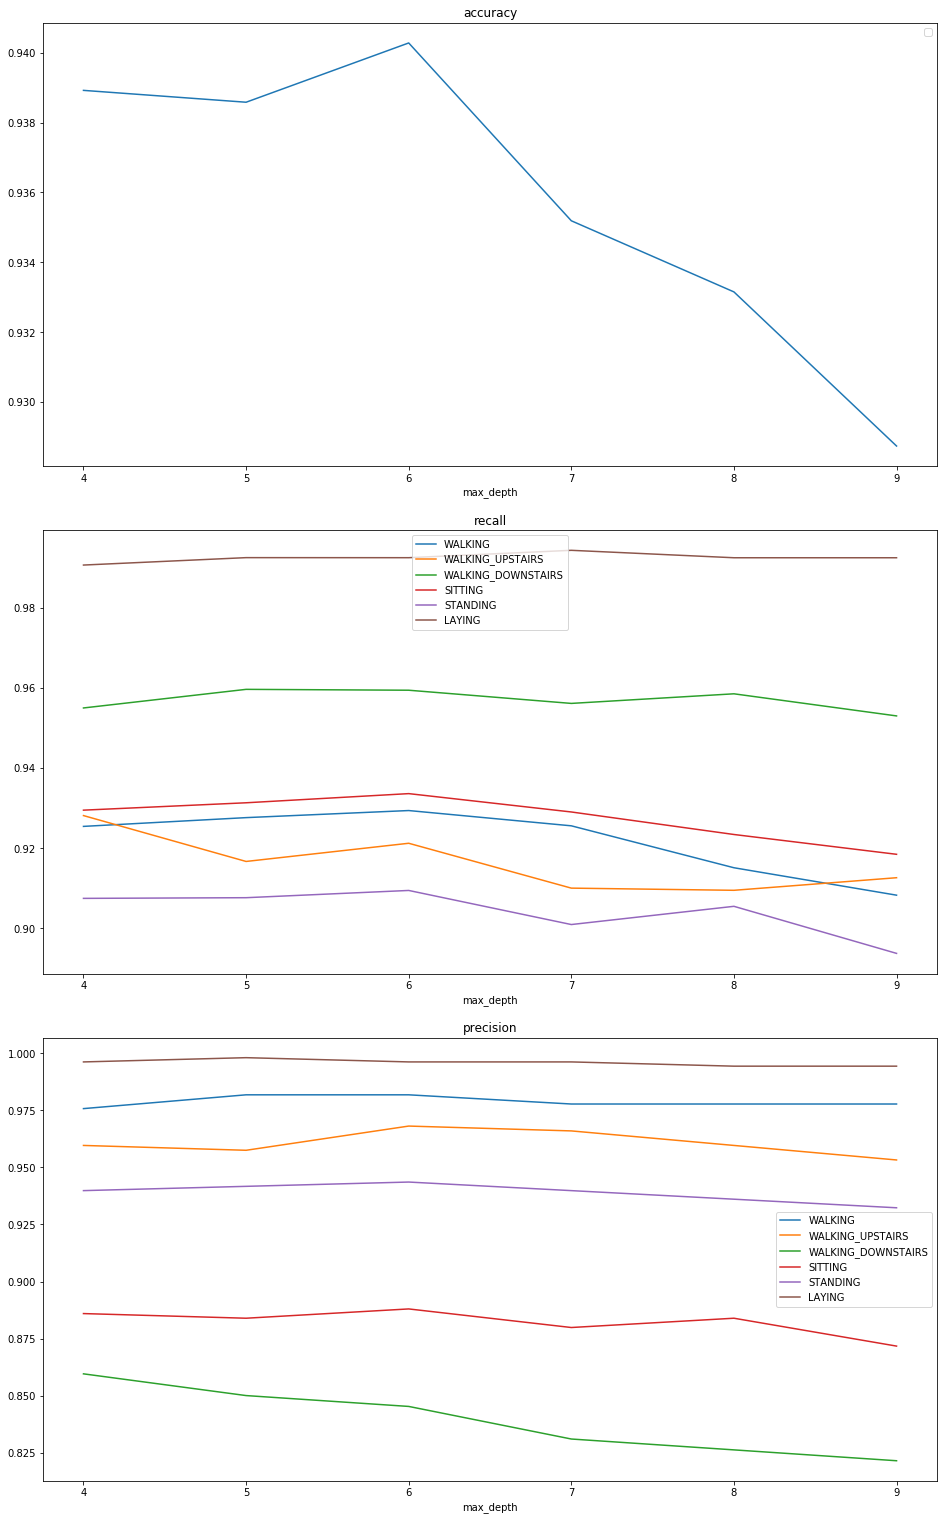

In [72]:
logger.plot(max_depth_range, 'max_depth')

* **Вывод** Лучше всего себя показала глубина 6

### Поэксперементируем с количеством деревьев (n_estimators)

In [109]:
n_estimators_list = []
logger = Logger(y_test, activity_labels)
n_estimators_list = list(np.linspace(300, 1500, 13).astype(np.int64))

for n_estimators in tqdm(n_estimators_list):
    model = ctb.CatBoostClassifier(n_estimators=n_estimators)
    model.fit(X_train_pca, y_train)
    clear_output(True)

    y_pred = model.predict(X_test_pca)
    logger.evaluate_predictions(y_pred)






100%|██████████| 13/13 [15:22<00:00, 70.98s/it]


No handles with labels found to put in legend.


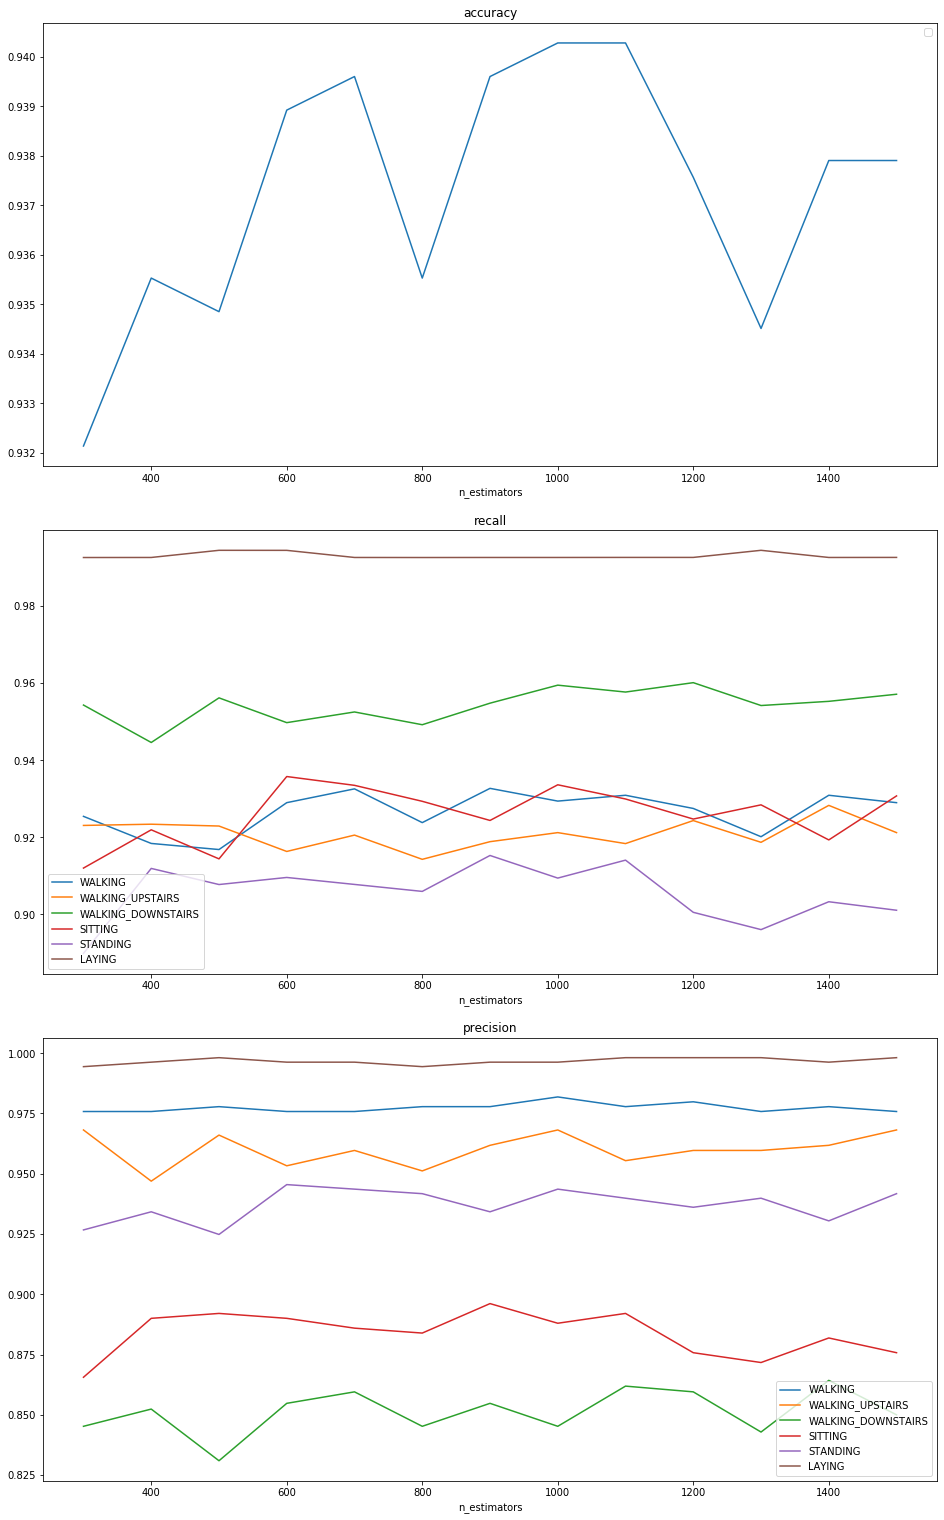

In [110]:
logger.plot(n_estimators_list, 'n_estimators')

* **Вывод** Лучше всего показала себя модель с числом деревьев от 1000 до 1100

### А теперь выполним случайный подбор параметров

In [141]:
%%time
gs = RandomizedSearchCV(
    ctb.CatBoostClassifier(),
    param_distributions={
        'max_depth': sps.randint(4, 10),
        'n_estimators': sps.randint(600, 1200),
    },
    cv=KFold(3),
    scoring='accuracy',
    n_jobs=4,
    random_state=0,
    n_iter=20
).fit(X_train_pca, y_train)
gs

Learning rate set to 0.078595
0:	learn: 1.6076016	total: 40.4ms	remaining: 45.9s
1:	learn: 1.4669714	total: 64.5ms	remaining: 36.6s
2:	learn: 1.3605616	total: 87.3ms	remaining: 33s
3:	learn: 1.2708836	total: 110ms	remaining: 31.3s
4:	learn: 1.1907705	total: 135ms	remaining: 30.5s
5:	learn: 1.1280796	total: 157ms	remaining: 29.7s
6:	learn: 1.0655443	total: 180ms	remaining: 29.1s
7:	learn: 1.0118287	total: 204ms	remaining: 28.8s
8:	learn: 0.9659649	total: 230ms	remaining: 28.8s
9:	learn: 0.9235391	total: 253ms	remaining: 28.5s
10:	learn: 0.8854492	total: 277ms	remaining: 28.4s
11:	learn: 0.8492261	total: 300ms	remaining: 28.2s
12:	learn: 0.8183871	total: 326ms	remaining: 28.2s
13:	learn: 0.7894141	total: 349ms	remaining: 28s
14:	learn: 0.7642527	total: 372ms	remaining: 27.8s
15:	learn: 0.7391705	total: 395ms	remaining: 27.7s
16:	learn: 0.7201995	total: 421ms	remaining: 27.7s
17:	learn: 0.7025225	total: 444ms	remaining: 27.6s
18:	learn: 0.6836315	total: 469ms	remaining: 27.6s
19:	learn: 0

161:	learn: 0.2119119	total: 4.25s	remaining: 25.6s
162:	learn: 0.2112062	total: 4.27s	remaining: 25.5s
163:	learn: 0.2104231	total: 4.3s	remaining: 25.5s
164:	learn: 0.2093259	total: 4.32s	remaining: 25.5s
165:	learn: 0.2084865	total: 4.38s	remaining: 25.6s
166:	learn: 0.2073606	total: 4.44s	remaining: 25.8s
167:	learn: 0.2064501	total: 4.51s	remaining: 26s
168:	learn: 0.2052472	total: 4.56s	remaining: 26.1s
169:	learn: 0.2044466	total: 4.59s	remaining: 26.1s
170:	learn: 0.2034293	total: 4.62s	remaining: 26.1s
171:	learn: 0.2026013	total: 4.64s	remaining: 26s
172:	learn: 0.2019543	total: 4.67s	remaining: 26s
173:	learn: 0.2012084	total: 4.69s	remaining: 26s
174:	learn: 0.2004403	total: 4.72s	remaining: 25.9s
175:	learn: 0.1995170	total: 4.74s	remaining: 25.9s
176:	learn: 0.1988448	total: 4.77s	remaining: 25.9s
177:	learn: 0.1982566	total: 4.79s	remaining: 25.8s
178:	learn: 0.1975157	total: 4.82s	remaining: 25.8s
179:	learn: 0.1967703	total: 4.84s	remaining: 25.7s
180:	learn: 0.1960241

327:	learn: 0.1234358	total: 9.49s	remaining: 23.4s
328:	learn: 0.1230559	total: 9.52s	remaining: 23.4s
329:	learn: 0.1226211	total: 9.54s	remaining: 23.3s
330:	learn: 0.1223883	total: 9.56s	remaining: 23.3s
331:	learn: 0.1220598	total: 9.58s	remaining: 23.2s
332:	learn: 0.1219097	total: 9.61s	remaining: 23.2s
333:	learn: 0.1216264	total: 9.63s	remaining: 23.2s
334:	learn: 0.1214520	total: 9.65s	remaining: 23.1s
335:	learn: 0.1209335	total: 9.68s	remaining: 23.1s
336:	learn: 0.1206081	total: 9.7s	remaining: 23s
337:	learn: 0.1202569	total: 9.72s	remaining: 23s
338:	learn: 0.1198745	total: 9.75s	remaining: 22.9s
339:	learn: 0.1193613	total: 9.77s	remaining: 22.9s
340:	learn: 0.1190871	total: 9.79s	remaining: 22.9s
341:	learn: 0.1187364	total: 9.82s	remaining: 22.8s
342:	learn: 0.1184408	total: 9.84s	remaining: 22.8s
343:	learn: 0.1182323	total: 9.86s	remaining: 22.7s
344:	learn: 0.1177681	total: 9.89s	remaining: 22.7s
345:	learn: 0.1175268	total: 9.91s	remaining: 22.7s
346:	learn: 0.117

487:	learn: 0.0880129	total: 13.6s	remaining: 18.1s
488:	learn: 0.0878624	total: 13.6s	remaining: 18.1s
489:	learn: 0.0876365	total: 13.7s	remaining: 18.1s
490:	learn: 0.0874647	total: 13.7s	remaining: 18s
491:	learn: 0.0873102	total: 13.7s	remaining: 18s
492:	learn: 0.0872515	total: 13.8s	remaining: 18s
493:	learn: 0.0870942	total: 13.8s	remaining: 18s
494:	learn: 0.0868725	total: 13.9s	remaining: 18s
495:	learn: 0.0867015	total: 13.9s	remaining: 18s
496:	learn: 0.0864805	total: 14s	remaining: 18s
497:	learn: 0.0863627	total: 14s	remaining: 17.9s
498:	learn: 0.0862311	total: 14s	remaining: 17.9s
499:	learn: 0.0860943	total: 14s	remaining: 17.9s
500:	learn: 0.0858853	total: 14.1s	remaining: 17.9s
501:	learn: 0.0856394	total: 14.1s	remaining: 17.8s
502:	learn: 0.0855829	total: 14.1s	remaining: 17.8s
503:	learn: 0.0854418	total: 14.1s	remaining: 17.8s
504:	learn: 0.0853585	total: 14.2s	remaining: 17.7s
505:	learn: 0.0851684	total: 14.2s	remaining: 17.7s
506:	learn: 0.0850382	total: 14.2s

650:	learn: 0.0657585	total: 18.8s	remaining: 14s
651:	learn: 0.0656419	total: 18.8s	remaining: 14s
652:	learn: 0.0655447	total: 18.9s	remaining: 14s
653:	learn: 0.0653671	total: 18.9s	remaining: 13.9s
654:	learn: 0.0652905	total: 18.9s	remaining: 13.9s
655:	learn: 0.0651939	total: 18.9s	remaining: 13.9s
656:	learn: 0.0651410	total: 19s	remaining: 13.8s
657:	learn: 0.0650372	total: 19s	remaining: 13.8s
658:	learn: 0.0649854	total: 19s	remaining: 13.8s
659:	learn: 0.0648812	total: 19s	remaining: 13.7s
660:	learn: 0.0647613	total: 19.1s	remaining: 13.7s
661:	learn: 0.0647113	total: 19.1s	remaining: 13.7s
662:	learn: 0.0645941	total: 19.2s	remaining: 13.7s
663:	learn: 0.0644955	total: 19.2s	remaining: 13.7s
664:	learn: 0.0643727	total: 19.2s	remaining: 13.6s
665:	learn: 0.0642956	total: 19.3s	remaining: 13.6s
666:	learn: 0.0642070	total: 19.3s	remaining: 13.6s
667:	learn: 0.0640489	total: 19.3s	remaining: 13.6s
668:	learn: 0.0639420	total: 19.4s	remaining: 13.5s
669:	learn: 0.0639013	tota

816:	learn: 0.0499764	total: 23.6s	remaining: 9.23s
817:	learn: 0.0498630	total: 23.6s	remaining: 9.2s
818:	learn: 0.0498170	total: 23.6s	remaining: 9.17s
819:	learn: 0.0497384	total: 23.6s	remaining: 9.14s
820:	learn: 0.0496884	total: 23.7s	remaining: 9.11s
821:	learn: 0.0496039	total: 23.7s	remaining: 9.08s
822:	learn: 0.0495257	total: 23.7s	remaining: 9.05s
823:	learn: 0.0494690	total: 23.7s	remaining: 9.02s
824:	learn: 0.0494364	total: 23.8s	remaining: 8.99s
825:	learn: 0.0493646	total: 23.8s	remaining: 8.96s
826:	learn: 0.0493160	total: 23.8s	remaining: 8.93s
827:	learn: 0.0492825	total: 23.9s	remaining: 8.91s
828:	learn: 0.0491909	total: 23.9s	remaining: 8.88s
829:	learn: 0.0491078	total: 23.9s	remaining: 8.85s
830:	learn: 0.0489990	total: 24s	remaining: 8.83s
831:	learn: 0.0489627	total: 24s	remaining: 8.8s
832:	learn: 0.0488516	total: 24s	remaining: 8.78s
833:	learn: 0.0488266	total: 24.1s	remaining: 8.75s
834:	learn: 0.0487345	total: 24.1s	remaining: 8.72s
835:	learn: 0.048640

982:	learn: 0.0387873	total: 27.8s	remaining: 4.35s
983:	learn: 0.0387394	total: 27.8s	remaining: 4.32s
984:	learn: 0.0386941	total: 27.8s	remaining: 4.29s
985:	learn: 0.0386195	total: 27.8s	remaining: 4.26s
986:	learn: 0.0385585	total: 27.9s	remaining: 4.24s
987:	learn: 0.0385355	total: 27.9s	remaining: 4.21s
988:	learn: 0.0384929	total: 28s	remaining: 4.18s
989:	learn: 0.0384524	total: 28s	remaining: 4.16s
990:	learn: 0.0383371	total: 28.1s	remaining: 4.13s
991:	learn: 0.0383130	total: 28.1s	remaining: 4.11s
992:	learn: 0.0382571	total: 28.2s	remaining: 4.08s
993:	learn: 0.0382023	total: 28.2s	remaining: 4.06s
994:	learn: 0.0381572	total: 28.3s	remaining: 4.03s
995:	learn: 0.0381317	total: 28.3s	remaining: 4.01s
996:	learn: 0.0380999	total: 28.4s	remaining: 3.98s
997:	learn: 0.0380706	total: 28.4s	remaining: 3.95s
998:	learn: 0.0380440	total: 28.4s	remaining: 3.93s
999:	learn: 0.0379973	total: 28.5s	remaining: 3.9s
1000:	learn: 0.0379516	total: 28.5s	remaining: 3.87s
1001:	learn: 0.0

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x1a1e1fd278>,
                   iid='deprecated', n_iter=20, n_jobs=4,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e1fd240>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e1fde80>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [148]:
model_gs = gs.best_estimator_
y_pred = model_gs.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.9402782490668476

### А теперь соберём вместе нашу модель 

In [149]:
model_hm = ctb.CatBoostClassifier(max_depth=6, n_estimators=1100)
model_hm.fit(X_train_pca, y_train)

Learning rate set to 0.080823
0:	learn: 1.5960603	total: 153ms	remaining: 2m 48s
1:	learn: 1.4412934	total: 227ms	remaining: 2m 4s
2:	learn: 1.3259865	total: 309ms	remaining: 1m 53s
3:	learn: 1.2325136	total: 384ms	remaining: 1m 45s
4:	learn: 1.1486374	total: 500ms	remaining: 1m 49s
5:	learn: 1.0775779	total: 591ms	remaining: 1m 47s
6:	learn: 1.0132261	total: 660ms	remaining: 1m 43s
7:	learn: 0.9586011	total: 738ms	remaining: 1m 40s
8:	learn: 0.9067890	total: 831ms	remaining: 1m 40s
9:	learn: 0.8609439	total: 998ms	remaining: 1m 48s
10:	learn: 0.8212717	total: 1.15s	remaining: 1m 53s
11:	learn: 0.7862397	total: 1.23s	remaining: 1m 51s
12:	learn: 0.7552010	total: 1.36s	remaining: 1m 53s
13:	learn: 0.7238862	total: 1.52s	remaining: 1m 57s
14:	learn: 0.6963763	total: 1.68s	remaining: 2m 1s
15:	learn: 0.6705314	total: 1.8s	remaining: 2m 2s
16:	learn: 0.6477188	total: 1.92s	remaining: 2m 2s
17:	learn: 0.6271502	total: 2.01s	remaining: 2m 1s
18:	learn: 0.6055771	total: 2.12s	remaining: 2m
19

158:	learn: 0.1422483	total: 16.3s	remaining: 1m 36s
159:	learn: 0.1415410	total: 16.4s	remaining: 1m 36s
160:	learn: 0.1407179	total: 16.5s	remaining: 1m 36s
161:	learn: 0.1399923	total: 16.6s	remaining: 1m 36s
162:	learn: 0.1391093	total: 16.8s	remaining: 1m 36s
163:	learn: 0.1383094	total: 16.9s	remaining: 1m 36s
164:	learn: 0.1378170	total: 17s	remaining: 1m 36s
165:	learn: 0.1370652	total: 17.1s	remaining: 1m 36s
166:	learn: 0.1363659	total: 17.2s	remaining: 1m 35s
167:	learn: 0.1357843	total: 17.3s	remaining: 1m 35s
168:	learn: 0.1350689	total: 17.4s	remaining: 1m 35s
169:	learn: 0.1343988	total: 17.5s	remaining: 1m 35s
170:	learn: 0.1335676	total: 17.6s	remaining: 1m 35s
171:	learn: 0.1328895	total: 17.7s	remaining: 1m 35s
172:	learn: 0.1322562	total: 17.8s	remaining: 1m 35s
173:	learn: 0.1315669	total: 17.9s	remaining: 1m 35s
174:	learn: 0.1312586	total: 18s	remaining: 1m 35s
175:	learn: 0.1306057	total: 18.2s	remaining: 1m 35s
176:	learn: 0.1299508	total: 18.3s	remaining: 1m 3

315:	learn: 0.0735159	total: 33.3s	remaining: 1m 22s
316:	learn: 0.0732426	total: 33.4s	remaining: 1m 22s
317:	learn: 0.0729541	total: 33.5s	remaining: 1m 22s
318:	learn: 0.0726877	total: 33.5s	remaining: 1m 22s
319:	learn: 0.0722829	total: 33.6s	remaining: 1m 21s
320:	learn: 0.0720069	total: 33.7s	remaining: 1m 21s
321:	learn: 0.0718155	total: 33.8s	remaining: 1m 21s
322:	learn: 0.0715888	total: 33.9s	remaining: 1m 21s
323:	learn: 0.0713114	total: 34s	remaining: 1m 21s
324:	learn: 0.0709618	total: 34s	remaining: 1m 21s
325:	learn: 0.0706997	total: 34.1s	remaining: 1m 21s
326:	learn: 0.0704043	total: 34.2s	remaining: 1m 20s
327:	learn: 0.0701890	total: 34.3s	remaining: 1m 20s
328:	learn: 0.0699232	total: 34.4s	remaining: 1m 20s
329:	learn: 0.0697039	total: 34.5s	remaining: 1m 20s
330:	learn: 0.0694376	total: 34.6s	remaining: 1m 20s
331:	learn: 0.0691339	total: 34.6s	remaining: 1m 20s
332:	learn: 0.0687694	total: 34.8s	remaining: 1m 20s
333:	learn: 0.0686223	total: 34.9s	remaining: 1m 1

473:	learn: 0.0448534	total: 48.6s	remaining: 1m 4s
474:	learn: 0.0446510	total: 48.7s	remaining: 1m 4s
475:	learn: 0.0445522	total: 48.8s	remaining: 1m 3s
476:	learn: 0.0444980	total: 48.8s	remaining: 1m 3s
477:	learn: 0.0443879	total: 48.9s	remaining: 1m 3s
478:	learn: 0.0442934	total: 49s	remaining: 1m 3s
479:	learn: 0.0441533	total: 49.1s	remaining: 1m 3s
480:	learn: 0.0439869	total: 49.2s	remaining: 1m 3s
481:	learn: 0.0438885	total: 49.2s	remaining: 1m 3s
482:	learn: 0.0437779	total: 49.3s	remaining: 1m 2s
483:	learn: 0.0437220	total: 49.4s	remaining: 1m 2s
484:	learn: 0.0436539	total: 49.5s	remaining: 1m 2s
485:	learn: 0.0434900	total: 49.6s	remaining: 1m 2s
486:	learn: 0.0433405	total: 49.8s	remaining: 1m 2s
487:	learn: 0.0432409	total: 49.9s	remaining: 1m 2s
488:	learn: 0.0430868	total: 50s	remaining: 1m 2s
489:	learn: 0.0429977	total: 50.1s	remaining: 1m 2s
490:	learn: 0.0429390	total: 50.1s	remaining: 1m 2s
491:	learn: 0.0428392	total: 50.2s	remaining: 1m 2s
492:	learn: 0.04

634:	learn: 0.0298033	total: 1m 7s	remaining: 49.5s
635:	learn: 0.0297138	total: 1m 7s	remaining: 49.4s
636:	learn: 0.0296718	total: 1m 7s	remaining: 49.2s
637:	learn: 0.0295813	total: 1m 7s	remaining: 49.1s
638:	learn: 0.0295486	total: 1m 7s	remaining: 49.1s
639:	learn: 0.0294761	total: 1m 8s	remaining: 49s
640:	learn: 0.0293874	total: 1m 8s	remaining: 48.9s
641:	learn: 0.0293017	total: 1m 8s	remaining: 48.8s
642:	learn: 0.0291920	total: 1m 8s	remaining: 48.7s
643:	learn: 0.0291316	total: 1m 8s	remaining: 48.6s
644:	learn: 0.0290408	total: 1m 8s	remaining: 48.5s
645:	learn: 0.0289911	total: 1m 8s	remaining: 48.4s
646:	learn: 0.0289365	total: 1m 8s	remaining: 48.3s
647:	learn: 0.0288478	total: 1m 9s	remaining: 48.2s
648:	learn: 0.0287780	total: 1m 9s	remaining: 48.1s
649:	learn: 0.0286797	total: 1m 9s	remaining: 48s
650:	learn: 0.0286065	total: 1m 9s	remaining: 47.9s
651:	learn: 0.0285749	total: 1m 9s	remaining: 47.9s
652:	learn: 0.0284785	total: 1m 9s	remaining: 47.8s
653:	learn: 0.02

792:	learn: 0.0211879	total: 1m 23s	remaining: 32.1s
793:	learn: 0.0211403	total: 1m 23s	remaining: 32s
794:	learn: 0.0210857	total: 1m 23s	remaining: 31.9s
795:	learn: 0.0210429	total: 1m 23s	remaining: 31.8s
796:	learn: 0.0210009	total: 1m 23s	remaining: 31.7s
797:	learn: 0.0209577	total: 1m 23s	remaining: 31.6s
798:	learn: 0.0209235	total: 1m 23s	remaining: 31.4s
799:	learn: 0.0208893	total: 1m 23s	remaining: 31.3s
800:	learn: 0.0208601	total: 1m 23s	remaining: 31.2s
801:	learn: 0.0207865	total: 1m 23s	remaining: 31.1s
802:	learn: 0.0207732	total: 1m 23s	remaining: 31s
803:	learn: 0.0207376	total: 1m 23s	remaining: 30.9s
804:	learn: 0.0206747	total: 1m 23s	remaining: 30.7s
805:	learn: 0.0206284	total: 1m 23s	remaining: 30.6s
806:	learn: 0.0205971	total: 1m 24s	remaining: 30.5s
807:	learn: 0.0205565	total: 1m 24s	remaining: 30.4s
808:	learn: 0.0205035	total: 1m 24s	remaining: 30.3s
809:	learn: 0.0204497	total: 1m 24s	remaining: 30.2s
810:	learn: 0.0203930	total: 1m 24s	remaining: 30.

948:	learn: 0.0157846	total: 1m 35s	remaining: 15.2s
949:	learn: 0.0157740	total: 1m 35s	remaining: 15.1s
950:	learn: 0.0157362	total: 1m 35s	remaining: 15s
951:	learn: 0.0157204	total: 1m 35s	remaining: 14.9s
952:	learn: 0.0157018	total: 1m 36s	remaining: 14.8s
953:	learn: 0.0156775	total: 1m 36s	remaining: 14.7s
954:	learn: 0.0156646	total: 1m 36s	remaining: 14.6s
955:	learn: 0.0156359	total: 1m 36s	remaining: 14.5s
956:	learn: 0.0156173	total: 1m 36s	remaining: 14.4s
957:	learn: 0.0155969	total: 1m 36s	remaining: 14.3s
958:	learn: 0.0155808	total: 1m 36s	remaining: 14.2s
959:	learn: 0.0155566	total: 1m 36s	remaining: 14.1s
960:	learn: 0.0155252	total: 1m 36s	remaining: 14s
961:	learn: 0.0154985	total: 1m 36s	remaining: 13.9s
962:	learn: 0.0154772	total: 1m 36s	remaining: 13.8s
963:	learn: 0.0154360	total: 1m 37s	remaining: 13.7s
964:	learn: 0.0154171	total: 1m 37s	remaining: 13.6s
965:	learn: 0.0153930	total: 1m 37s	remaining: 13.5s
966:	learn: 0.0153605	total: 1m 37s	remaining: 13.

In [153]:
y_pred = model_hm.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.9402782490668476

### Построим ROC-AUC кривую для данных моделей

* Для модели, полученной при помощи случайного поиска по сетке

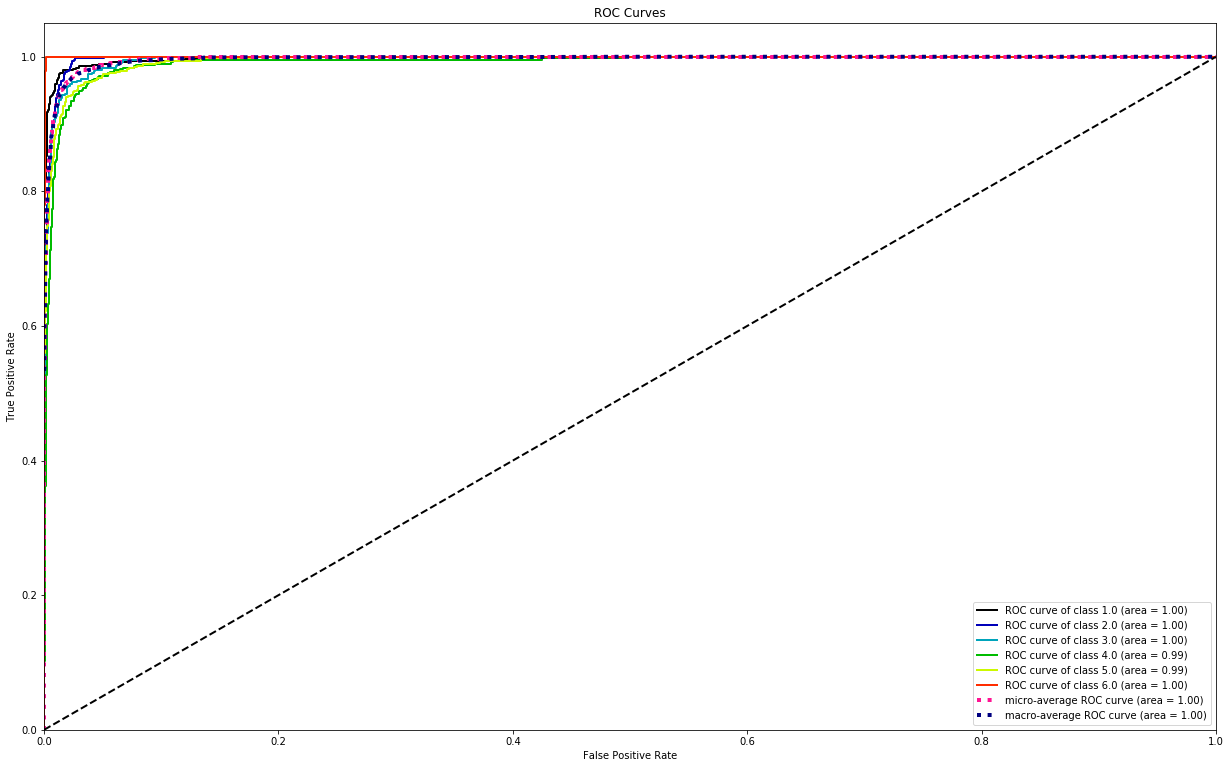

In [172]:
y_probas = model_gs.predict_proba(X_test_pca)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(21, 13))
plt.show()

* Для модели, полученной при помощи ручного поиска оптимальных параметров

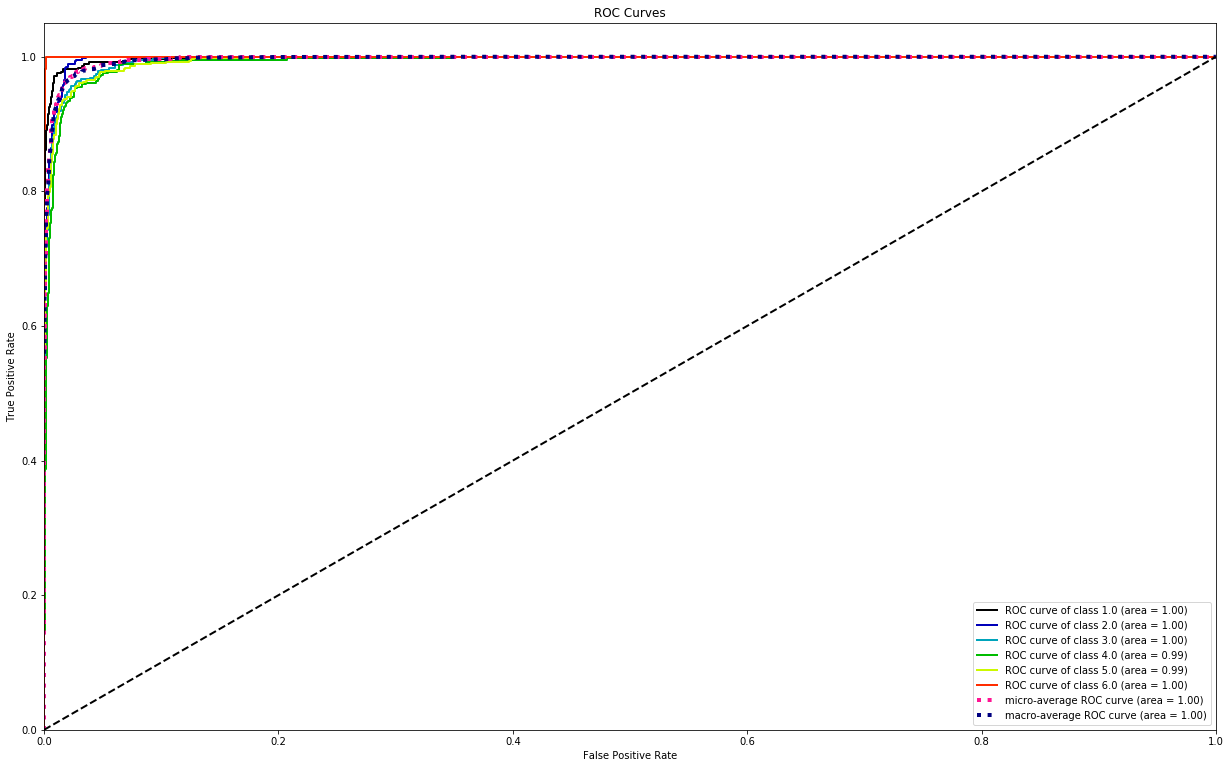

In [173]:
y_probas = model_hm.predict_proba(X_test_pca)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(21, 13))
plt.show()

### Вывод:

В этом задании была предоставлена свобода действий, поэтому я решил изучить, как лучше всего искать оптимальные параметры.

Выделил два подхода:

1. искать оптимум для каждого параметра, а потом собирать модель из найденных оптимальных (Предполагается, что параметры независимы и если какой-то параметр является оптимальным, то он оптимальный при любом наборе прочих параметров. Что, конечно, **не всегда** выполняется)

2. Поиск параметров при помощи случайного поиска по сетке.

Как можно видеть оба подхода показали хороший результат, получив точность 0.94. Кстати такую же точность получила и базовая модель. Мне кажется это связано с тем, что стандартные параметры являются близкими к оптимальным для данного датасета. 

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [ ]:
# Your code here

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [ ]:
# Your code here.